## Hospitality App New User Bookings

### Objective
1. Data Exploration
2. Data Processing
3. Feature Engineering
4. Model Building

In [1]:
## import necessary packages
import numpy as np
import pandas as pd
import time
import random
import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import gc
%matplotlib inline
plt.style.use('ggplot')

In [2]:
## Type your answers here ##
user_booking = pd.read_csv('train_users_2.csv')
new_user = pd.read_csv('test_users.csv')

In [4]:
print(user_booking.shape)
print(user_booking.columns)

(213451, 16)
Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')


## 1. Data Exploration

In [5]:
user_booking.head(5)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [6]:
user_booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


## 2. EDA

### Uni-variate analysis

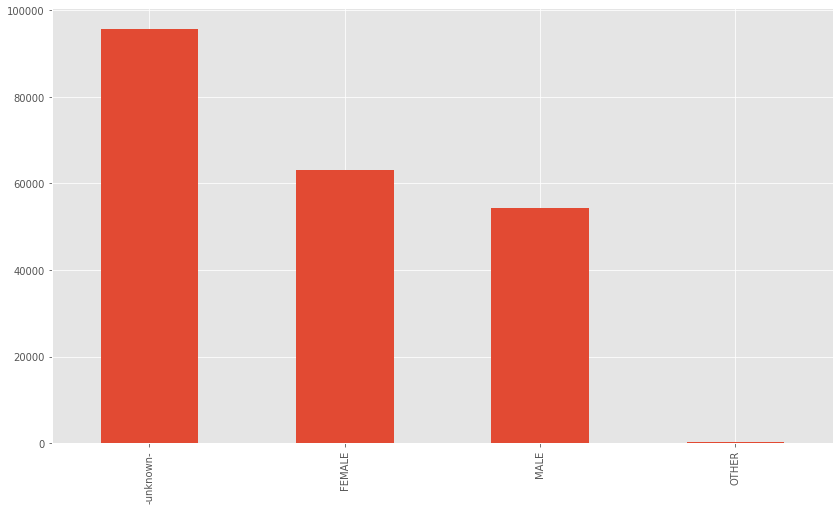

In [8]:
# explore gender
plt.figure(figsize = [14,8])
user_booking.gender.value_counts().plot.bar()

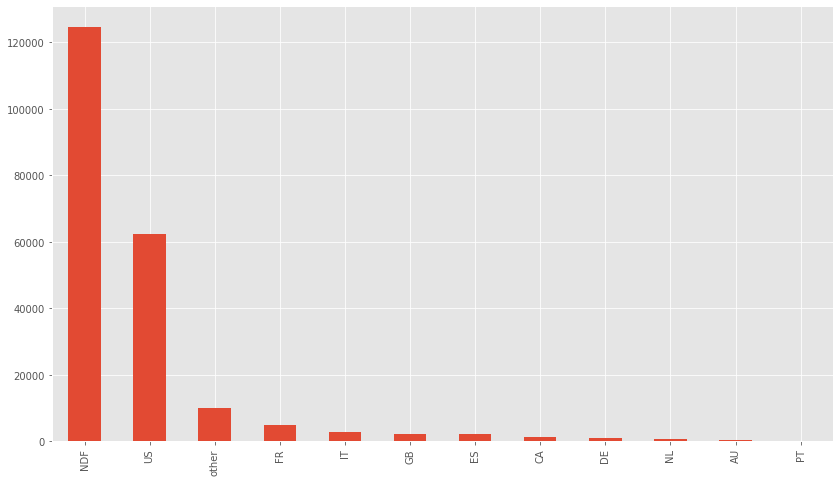

In [9]:
# see the distribution of destination
plt.figure(figsize = [14,8])
user_booking['country_destination'].value_counts().plot.bar()

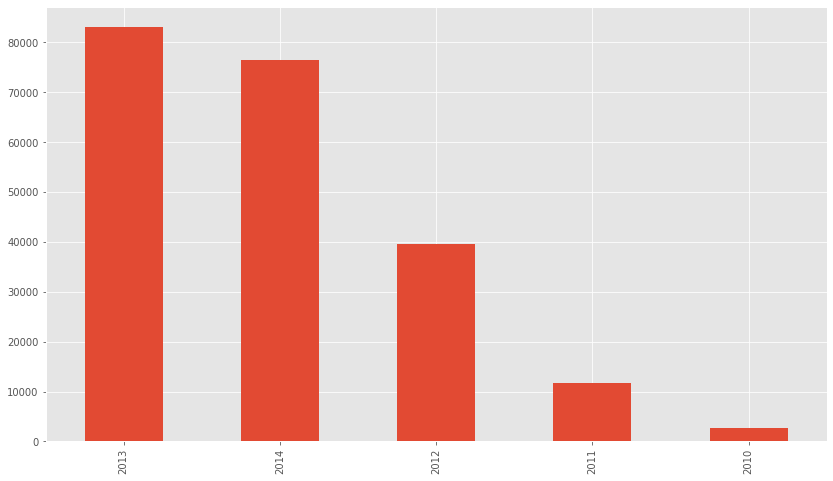

In [12]:
# explore date account created
plt.figure(figsize = [14,8])
pd.to_datetime(user_booking['date_account_created']).dt.year.value_counts().plot.bar()

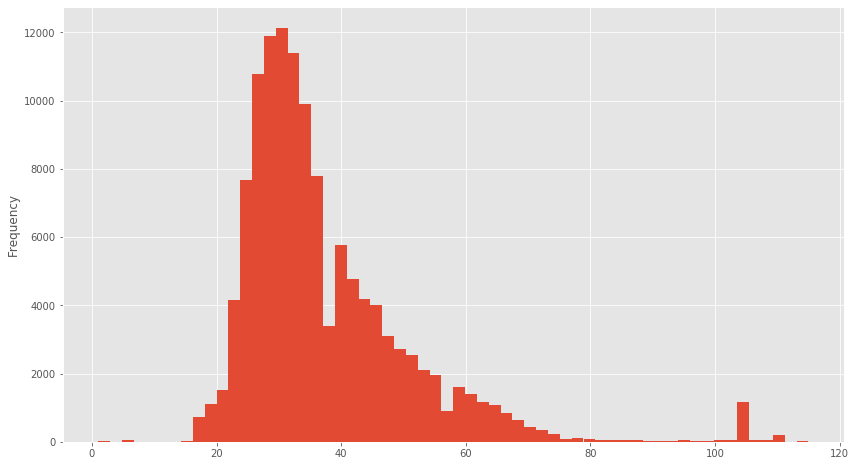

In [13]:
# see the age distribution
plt.figure(figsize = [14,8])
user_booking.loc[user_booking['age']<120]['age'].plot.hist(bins=60)

### Bi-variate analysis

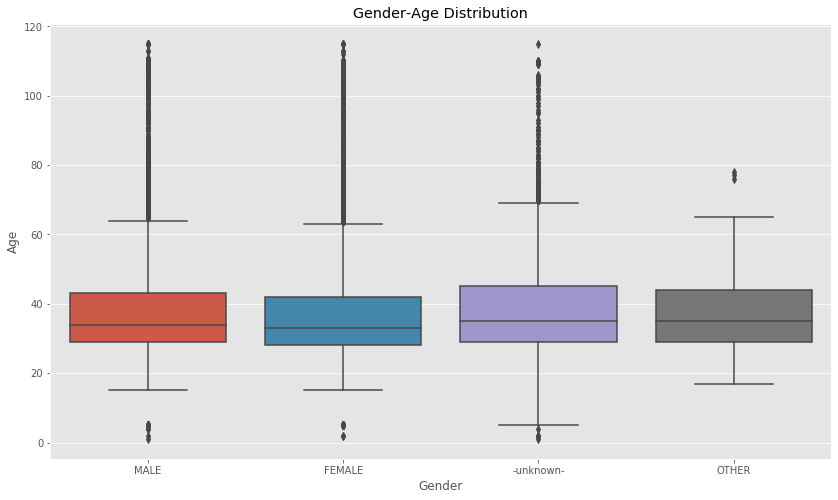

In [16]:
# Gender-Age Distribution plot
plt.figure(figsize = [14,8])
sns.boxplot(data=user_booking[user_booking.age < 120],y='age',x='gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.title('Gender-Age Distribution')
plt.show()

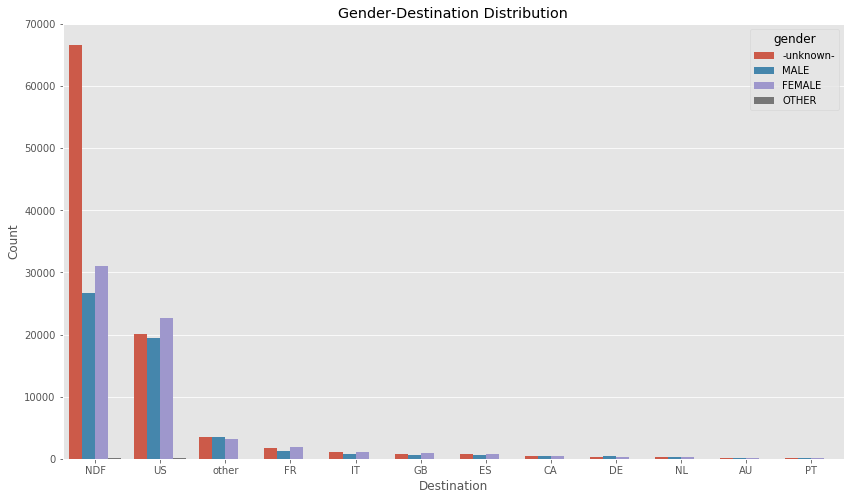

In [17]:
# Gender-Destination Distribution Plot
plt.figure(figsize = [14,8])
order1 = user_booking['country_destination'].value_counts().index
sns.countplot(data=user_booking, x = 'country_destination',order = order1, hue = 'gender')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Gender-Destination Distribution')
order2 = user_booking['country_destination'].value_counts()

## 3. Feature Engineering

In [3]:
labels = user_booking['country_destination'].values

user_booking.drop(['country_destination','date_first_booking'],axis=1,inplace=True) # date_first_booking has too many null values

### date_account_created (dac)

In [4]:
dac = pd.to_datetime(user_booking.date_account_created)
user_booking['dac_year'] = np.array([x.year for x in dac])
user_booking['dac_month'] = np.array([x.month for x in dac])
user_booking['dac_day'] = np.array([x.day for x in dac])

In [5]:
user_booking['dac_wd'] = np.array([x.isoweekday() for x in dac])
df_dac_wd = pd.get_dummies(user_booking.dac_wd, prefix = 'dac_wd')
user_booking = pd.concat((user_booking,df_dac_wd),axis = 1)
user_booking.drop(['dac_wd'],inplace = True,axis = 1)

In [6]:
def get_season(dt):
    dt = dt.date()
    if dt.month in [3,4,5]:
        return 'Spring'
    elif dt.month in [6,7,8]:
        return 'Summer'
    elif dt.month in [9,10,11]:
        return 'Fall'
    else:
        return 'Winter'

In [7]:
user_booking['dac_season'] = np.array([get_season(x) for x in dac])
df_dac_season = pd.get_dummies(user_booking.dac_season, prefix = 'dac_season')
user_booking = pd.concat((user_booking,df_dac_season),axis = 1)
user_booking.drop(['dac_season'],axis = 1, inplace = True)

### timestamp_first_active (tfa)

In [8]:
tfa = user_booking['timestamp_first_active'].astype(str).apply(
    lambda x: datetime.datetime(int(x[:4]),
                                int(x[4:6]),
                                int(x[6:8]),
                                int(x[8:10]),
                                int(x[10:12]),
                                int(x[12:])))

In [9]:
user_booking['tfa_year'] = np.array([x.year for x in tfa])
user_booking['tfa_month'] = np.array([x.month for x in tfa])
user_booking['tfa_day'] = np.array([x.day for x in tfa])

In [10]:
user_booking['tfa_wd'] = np.array([x.isoweekday() for x in tfa])
df_tfa_wd = pd.get_dummies(user_booking.tfa_wd, prefix = 'dac_wd')
user_booking = pd.concat((user_booking,df_tfa_wd),axis = 1)
user_booking.drop(['tfa_wd'],inplace = True,axis = 1)

In [11]:
user_booking['tfa_season'] = np.array([get_season(x) for x in tfa])
df_tfa_season = pd.get_dummies(user_booking.tfa_season, prefix = 'dac_season')
user_booking = pd.concat((user_booking,df_tfa_season),axis = 1)
user_booking.drop(['tfa_season'],axis = 1, inplace = True)

### Time span between dac and tfa can also be used as feature

In [12]:
df_span = (dac - tfa).dt.seconds
user_booking['df_span'] = np.array([x for x in df_span])

### Deal with Age

In [13]:
age = user_booking['age']
age.fillna(-1,inplace = True)

/usr/local/lib64/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [14]:
age.describe()

count    213451.000000
mean         28.781542
std         121.922097
min          -1.000000
25%          -1.000000
50%          26.000000
75%          36.000000
max        2014.000000
Name: age, dtype: float64

In [15]:
age[age > 120].value_counts()

2014.0    710
2013.0     39
1932.0      3
1949.0      3
1931.0      3
1936.0      2
1947.0      2
1928.0      2
1929.0      2
1924.0      2
1933.0      1
1952.0      1
150.0       1
132.0       1
1938.0      1
1927.0      1
1995.0      1
1935.0      1
2008.0      1
1953.0      1
1926.0      1
1925.0      1
1942.0      1
Name: age, dtype: int64

<AxesSubplot:ylabel='Frequency'>

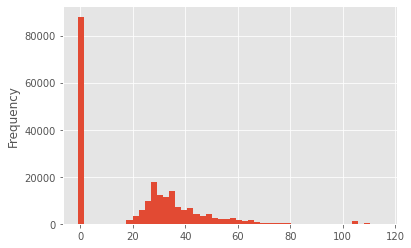

In [16]:
age[age < 120].plot.hist(bins=50)

In [17]:
# This is a birthday year rather than age
age = np.where(np.logical_and(age < 2005, age > 1900), 2020 - age, age)
# This is the current year still mark na
age = np.where(np.logical_and(age < 2016, age > 2005), -1, age)

In [18]:
interval = 15

def get_age(age):
    if age < 0:
        return 'NA'
    elif (age < interval):
        return interval
    elif (age <= interval*2):
        return interval*2
    elif (age <= interval*3):
        return interval*3
    elif (age <= interval*4):
        return interval*4
    elif (age <= interval*5):
        return interval*5
    elif (age <= interval*6):
        return interval*6
    elif (age <= interval*7):
        return interval*7
    else:
        return 'Unphysical'

In [19]:
user_booking['age'] = np.array([get_age(x) for x in age])
df_age = pd.get_dummies(user_booking['age'], prefix='age')
user_booking = pd.concat((user_booking,df_age),axis = 1)

## Label Encoding and One Hot Encoding

In [20]:
pd.set_option('display.max_columns',None)

In [26]:
feature_OHE = ['gender','signup_method',
               'signup_flow','language',
               'affiliate_channel','affiliate_provider',
               'first_affiliate_tracked','signup_app',
               'first_device_type','first_browser']

### Label Encoding
* Prequisite for OHE Encoding

In [27]:
from sklearn import preprocessing
LBL = preprocessing.LabelEncoder()

LE_vars = []
LE_map = dict()
LE_map1 = dict()
for cat_var in feature_OHE:
    print("Label Encoding %s" % (cat_var))
    LE_var = cat_var + '_le'
    user_booking[LE_var] = LBL.fit_transform(user_booking[cat_var].fillna('none'))
    LE_vars.append(LE_var)
    LE_map1[cat_var] = dict(zip(LBL.classes_, LBL.transform(LBL.classes_)))
    LE_map[cat_var] = LBL.classes_

print("Label-encoded features: %s" % (LE_vars))

Label Encoding gender
Label Encoding signup_method
Label Encoding signup_flow
Label Encoding language
Label Encoding affiliate_channel
Label Encoding affiliate_provider
Label Encoding first_affiliate_tracked
Label Encoding signup_app
Label Encoding first_device_type
Label Encoding first_browser
Label-encoded features: ['gender_le', 'signup_method_le', 'signup_flow_le', 'language_le', 'affiliate_channel_le', 'affiliate_provider_le', 'first_affiliate_tracked_le', 'signup_app_le', 'first_device_type_le', 'first_browser_le']


### One Hot Encoding

In [28]:
%%time
OHE = preprocessing.OneHotEncoder(sparse = False)
OHE.fit(user_booking[LE_vars])
OHE_data = OHE.transform(user_booking[LE_vars])

OHE_vars = [var[:-3] + '_' + str(level).replace(' ','_')\
            for var in feature_OHE for level in LE_map[var]]

CPU times: user 352 ms, sys: 242 ms, total: 593 ms
Wall time: 590 ms


In [29]:
user_booking = pd.concat((user_booking,pd.DataFrame(OHE_data, columns = OHE_vars)),axis = 1)

## Model Building

### Airbnb Evaluation: NDCG

In [49]:
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelBinarizer

def dcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    
    gain = 2**y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)
    
    scores = []
    
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)
    return np.mean(scores)

In [31]:
labels_le = preprocessing.LabelEncoder()
ytrain = labels_le.fit_transform(labels)
label_map = dict(zip(labels_le.classes_, labels_le.transform(labels_le.classes_)))

### Logistic Regression

In [51]:
xtrain = user_booking.drop(['id','age','date_account_created','timestamp_first_active'],axis=1).drop(feature_OHE+LE_vars,axis=1)

In [35]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [52]:
lr = LogisticRegression()

In [53]:
lr.fit(xtrain,ytrain)

/home/syin/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [39]:
predict = lr.predict_proba(xtrain)

In [40]:
np.argsort(predict[1])

array([ 9,  0,  8,  2,  1,  3,  5,  6,  4, 11, 10,  7])

In [41]:
predict[1]

array([0.00486891, 0.00722509, 0.00639451, 0.00958433, 0.02073962,
       0.01023024, 0.01120931, 0.56948831, 0.00591509, 0.0032939 ,
       0.29876163, 0.05228906])

In [50]:
k_ndcg = 5
train_ndcg_score = ndcg_score(ytrain[:1000], predict[:1000], k =k_ndcg)
train_ndcg_score

0.7472915781902215

### Decision Tree

In [54]:
xtrain = user_booking.drop(['id','age','date_account_created','timestamp_first_active'],axis=1).drop(feature_OHE+LE_vars,axis=1)

In [55]:
from sklearn.tree import DecisionTreeClassifier

In [56]:
dt = DecisionTreeClassifier(max_depth=5)

In [57]:
dt.fit(xtrain,ytrain)

DecisionTreeClassifier(max_depth=5)

In [58]:
predict = dt.predict_proba(xtrain)

In [59]:
np.argsort(predict[1])

array([ 9,  0,  8,  1,  2,  5,  3,  6,  4, 11, 10,  7])

In [60]:
predict[1]

array([0.00268437, 0.00671094, 0.00720543, 0.0127861 , 0.0267731 ,
       0.01271546, 0.01384572, 0.50939531, 0.00437977, 0.00105962,
       0.34854479, 0.05389941])

In [61]:
k_ndcg = 5
train_ndcg_score = ndcg_score(ytrain[:1000], predict[:1000], k =k_ndcg)
train_ndcg_score

0.7857413435860244

### Random Forest

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
rf = RandomForestClassifier(n_estimators = 50, max_depth = 9, random_state = 42)

In [64]:
rf.fit(xtrain,ytrain)

RandomForestClassifier(max_depth=9, n_estimators=50, random_state=42)

In [65]:
predict = rf.predict_proba(xtrain)

In [66]:
np.argsort(predict[1])

array([ 9,  0,  8,  2,  5,  1,  3,  6,  4, 11, 10,  7])

In [67]:
predict[1]

array([0.00246941, 0.0128568 , 0.00663176, 0.01304121, 0.02706154,
       0.01245709, 0.01352069, 0.48345151, 0.00526273, 0.00152561,
       0.37018479, 0.05153687])

In [68]:
k_ndcg = 5
train_ndcg_score = ndcg_score(ytrain[:1000], predict[:1000], k =k_ndcg)
train_ndcg_score

0.80378759209331